### Importar librerias y configuraciones

In [58]:
import os
import re
import glob
import fiona
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sn
import rasterio.mask
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import multiprocessing

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Preprocesado y modelado
# ==============================================================================
from time import time
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance

# Configuración warnings
# ==============================================================================
#import warnings
#warnings.filterwarnings('once')

### Importar base de datos

In [59]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DSM               33 non-null     float64
 1   EVAPO             33 non-null     float64
 2   PP                33 non-null     float64
 3   TEMP              33 non-null     float64
 4   GNDVI_mean        33 non-null     float64
 5   GNDVI_stde        33 non-null     float64
 6   GNDVI_range       33 non-null     float64
 7   NDRE_mean         33 non-null     float64
 8   NDRE_stde         33 non-null     float64
 9   NDRE_range        33 non-null     float64
 10  NDVI_mean         33 non-null     float64
 11  NDVI_stde         33 non-null     float64
 12  NDVI_range        33 non-null     float64
 13  OSAVI_mean        33 non-null     float64
 14  OSAVI_stde        33 non-null     float64
 15  OSAVI_range       33 non-null     float64
 16  RECI_mean         33 non-null     float64
 17 

# RFR 1 - Modelo de todas las variables (sin optimizar)

In [60]:
### División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = ["REND_mean"]),
                                        df['REND_mean'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 24,
            criterion    = 'squared_error', #'mse' 
            max_depth    = None,
            max_features = 28,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)


RandomForestRegressor(max_features=28, n_estimators=24, n_jobs=-1,
                      random_state=123)

In [61]:
# Error de test del modelo inicial
# ========================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")

El error (rmse) de test es: 2.211849315637717
El MAPE de test es: 0.3030383384155824


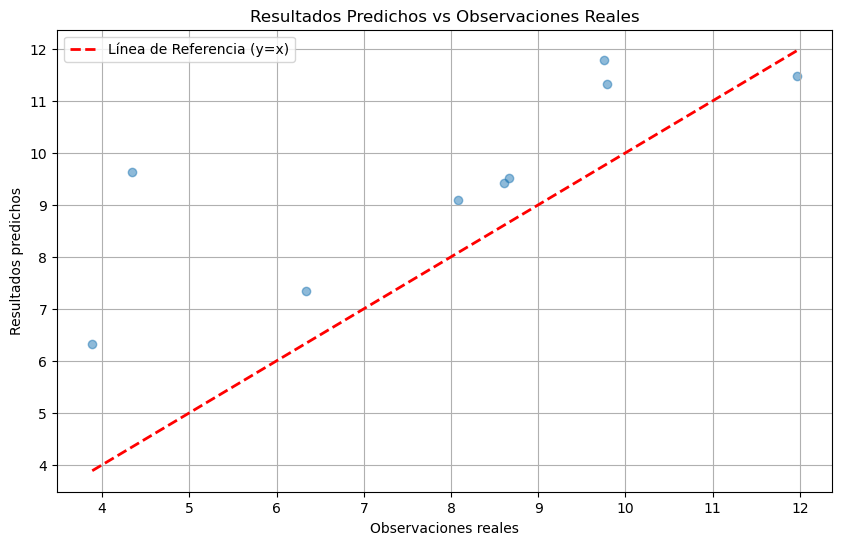

In [62]:
# Gráfico de dispersión de los resultados predichos frente a las observaciones reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()

## Importancia de predictores

#### Importancia por pureza de nodos


In [63]:
importancia_df = pd.DataFrame(
                            {'predictor': df.drop(columns = "REND_mean").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
df1 = importancia_df.sort_values('importancia', ascending=False)
print(df1)

Importancia de los predictores en el modelo
-------------------------------------------
           predictor  importancia
26        TCARI_stde     0.158606
7          NDRE_mean     0.134242
2                 PP     0.111280
4         GNDVI_mean     0.081966
22   TCARIOSAVI_mean     0.077997
3               TEMP     0.060988
1              EVAPO     0.056898
25        TCARI_mean     0.054269
27       TCARI_range     0.042476
6        GNDVI_range     0.028563
15       OSAVI_range     0.020686
23   TCARIOSAVI_stde     0.018530
11         NDVI_stde     0.016874
8          NDRE_stde     0.015845
14        OSAVI_stde     0.014090
9         NDRE_range     0.012332
24  TCARIOSAVI_range     0.012168
10         NDVI_mean     0.011444
16         RECI_mean     0.011402
0                DSM     0.011184
21       SLOPE_range     0.010202
20        SLOPE_stde     0.009619
18        RECI_range     0.007356
19        SLOPE_mean     0.007211
13        OSAVI_mean     0.005640
17         RECI_stde     0.0

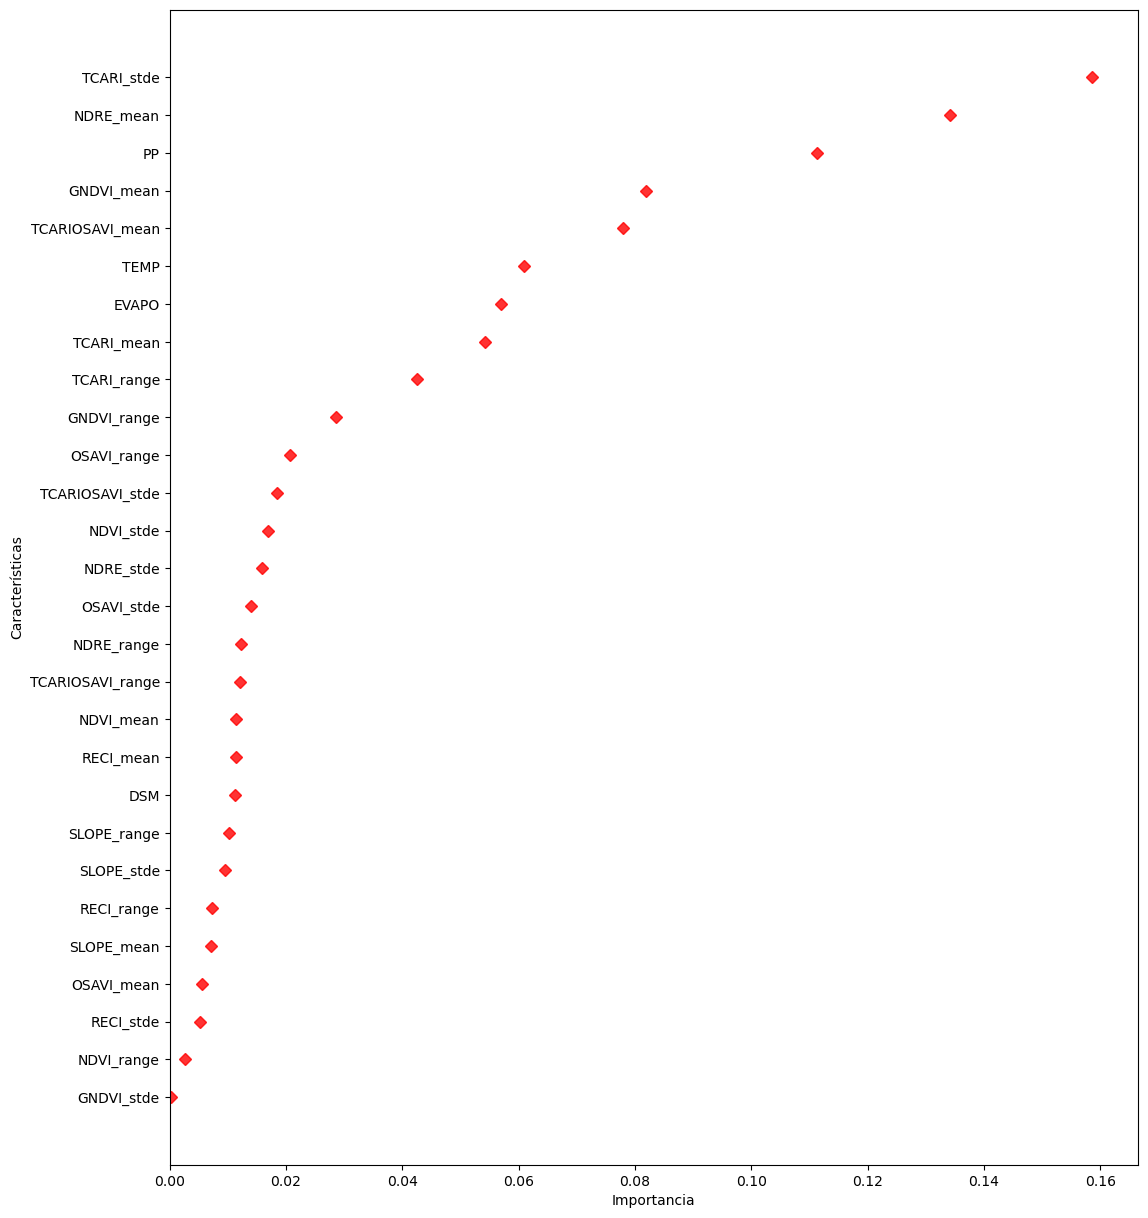

In [64]:
# Modificación del gráfico para feature_importances_
fig, ax = plt.subplots(figsize=(12.5, 15))
importancia_df = importancia_df.sort_values('importancia', ascending=True)  # Ordenar de mayor a menor importancia

# Barras horizontales
ax.barh(
    importancia_df['predictor'],
    importancia_df['importancia'],
    align='center',
    alpha=0,
)

# Puntos de importancia
ax.plot(
    importancia_df['importancia'],
    importancia_df['predictor'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)

# Etiquetas en el eje x y el eje y
ax.set_xlabel('Importancia')
ax.set_ylabel('Características')
#ax.set_title('Importancia de las Características')

plt.show()


#### Importancia por permutación

In [65]:
importancia = permutation_importance(
                estimator    = modelo,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df1 = df_importancia.sort_values('importances_mean', ascending=False)
#df_importancia.sort_values('importancia', ascending=False)
print(df1)

    importances_mean  importances_std           feature
26          0.525354         0.109272        TCARI_stde
7           0.295387         0.035778         NDRE_mean
22          0.156412         0.066755   TCARIOSAVI_mean
2           0.136987         0.102862                PP
4           0.128203         0.036484        GNDVI_mean
25          0.089772         0.063268        TCARI_mean
3           0.081067         0.021508              TEMP
1           0.069825         0.044942             EVAPO
27          0.058098         0.018075       TCARI_range
0           0.054788         0.015278               DSM
8           0.054594         0.007820         NDRE_stde
14          0.047838         0.017274        OSAVI_stde
23          0.044261         0.015632   TCARIOSAVI_stde
16          0.040504         0.010034         RECI_mean
18          0.032666         0.008645        RECI_range
24          0.027185         0.012605  TCARIOSAVI_range
11          0.020785         0.004831         ND

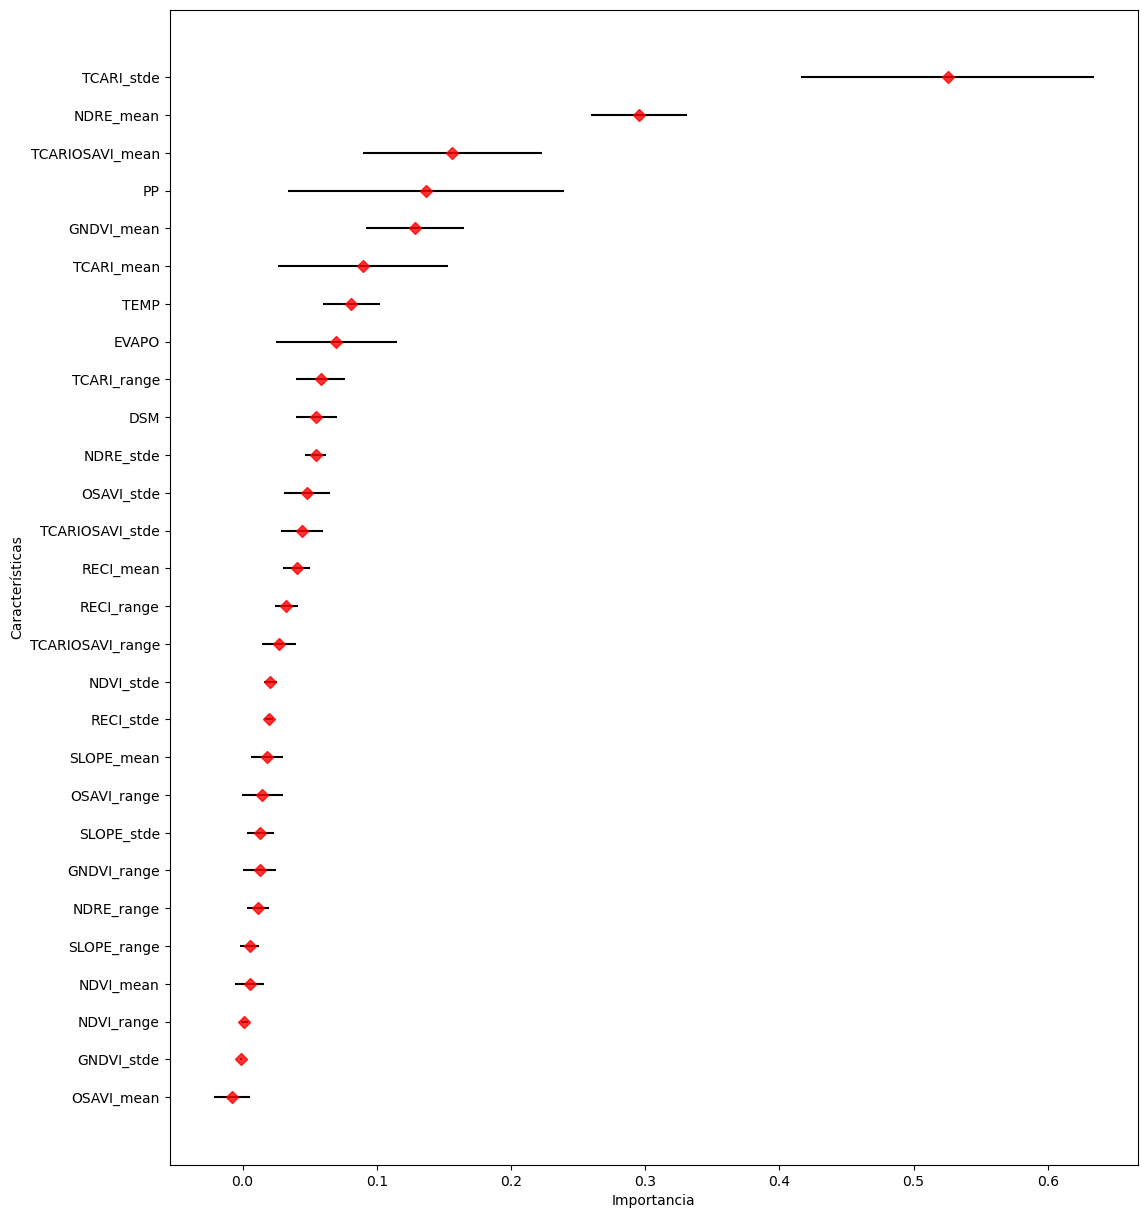

In [66]:
# Gráfico
fig, ax = plt.subplots(figsize=(12.5, 15))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
# Etiquetas en el eje x y el eje y
ax.set_xlabel('Importancia')
ax.set_ylabel('Características')
#ax.set_title('Importancia de las Características')

plt.show()

# RFR 2 - Modelo de todas las variables (optimizado)


## Optimización de hiperparámetros - Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, 
solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. 
Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.



#### Validación empleando el Out-of-Bag error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensem

Valor óptimo de n_estimators: 112


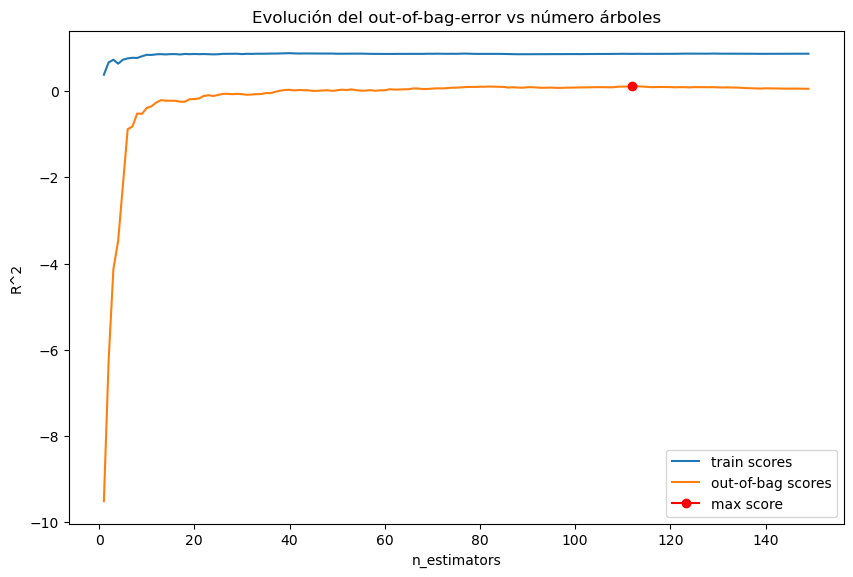

In [67]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

Valor óptimo de n_estimators: 5


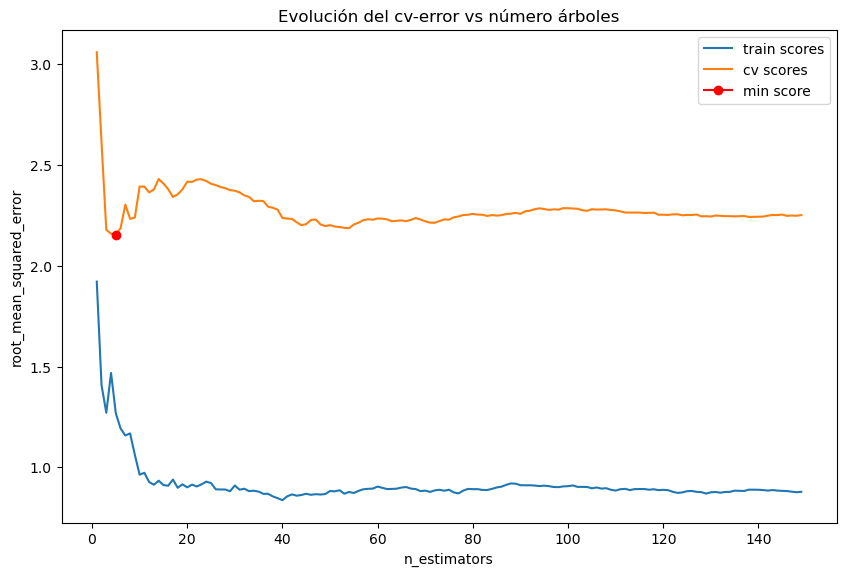

In [68]:
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Max features

El valor de máx_features es uno de los hiperparámetros más importantes de random forest, 
ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


#### Validación empleando el Out-of-Bag error

Valor óptimo de max_features: 4


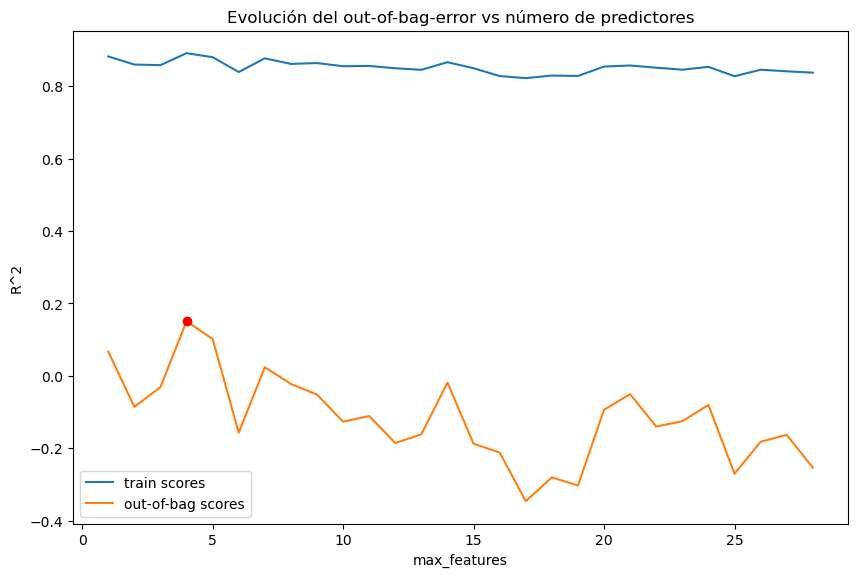

In [69]:
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 24,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

Valor óptimo de max_features: 25


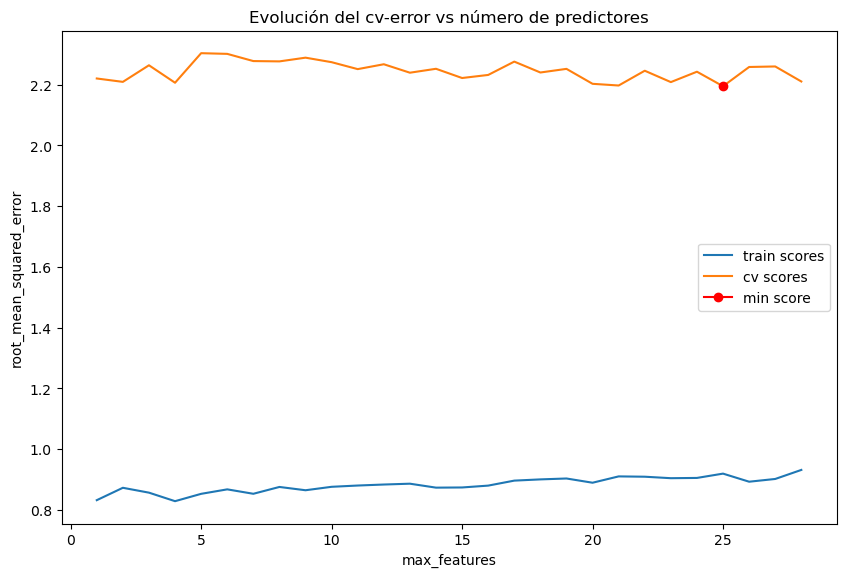

In [70]:
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 150,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Numero de arboles + Max Features (Grid search)

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo 
e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, 
ya que cada hiperparámetro interacciona con los demás. 
Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. 

#### Grid Search basado en out-of-bag error

In [71]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [None, 7, 25],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 25, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
1,0.136262,NaN,7.0,150.0
7,0.136262,10.0,7.0,150.0
10,0.136262,20.0,7.0,150.0
4,0.126559,3.0,7.0,150.0


In [72]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0:])

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
oob_r2            0.136262
max_depth              NaN
max_features      7.000000
n_estimators    150.000000
Name: 1, dtype: float64


#### Grid Search basado en validación cruzada

In [73]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [None,7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = multiprocessing.cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
1,None,7,150,-2.149713,0.829797,-0.855338,0.104023
7,10,7,150,-2.149713,0.829797,-0.855338,0.104023
10,20,7,150,-2.149713,0.829797,-0.855338,0.104023
4,3,7,150,-2.164897,0.790265,-0.952929,0.115405


In [74]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': None, 'max_features': 7, 'n_estimators': 150} : -2.149713016559 neg_root_mean_squared_error


In [75]:
# Error de test del modelo final
# =============================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")



El error (rmse) de test es: 2.5518464741220352
El MAPE de test es: 0.3556865790827425


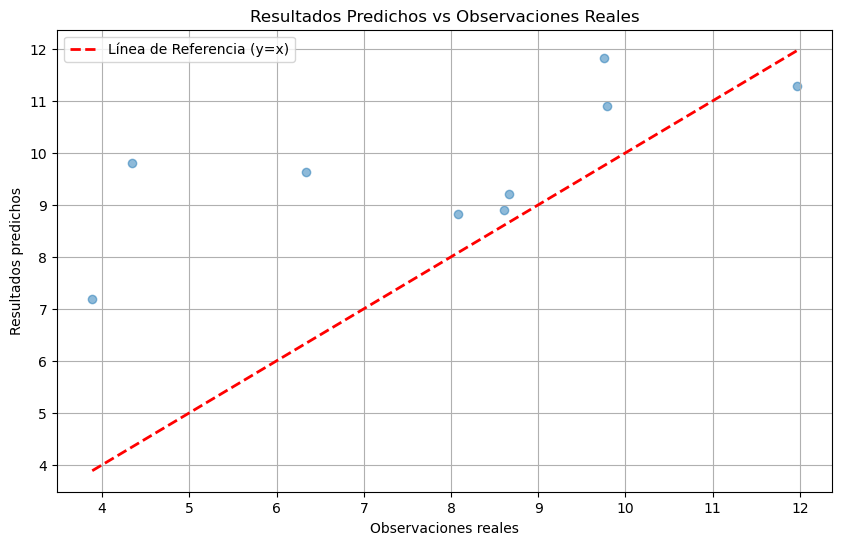

In [76]:
# Gráfico de dispersión de los resultados predichos frente a las observaciones reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()

# RFR 3 - Modelo de las variables seleccionadas por importancia 

In [77]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])

y = df[['REND_mean']].to_numpy()
df = df.drop(columns = [
'DSM',
'NDVI_stde',
'NDRE_stde',
'OSAVI_stde',
'NDRE_range',
'TCARIOSAVI_range',
'NDVI_mean',
'RECI_mean',
'SLOPE_range',
'SLOPE_stde',
'RECI_range',
'SLOPE_mean',
'OSAVI_mean',
'RECI_stde',
'NDVI_range',
'GNDVI_stde'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   EVAPO            33 non-null     float64
 1   PP               33 non-null     float64
 2   TEMP             33 non-null     float64
 3   GNDVI_mean       33 non-null     float64
 4   GNDVI_range      33 non-null     float64
 5   NDRE_mean        33 non-null     float64
 6   OSAVI_range      33 non-null     float64
 7   TCARIOSAVI_mean  33 non-null     float64
 8   TCARIOSAVI_stde  33 non-null     float64
 9   TCARI_mean       33 non-null     float64
 10  TCARI_stde       33 non-null     float64
 11  TCARI_range      33 non-null     float64
 12  REND_mean        33 non-null     float64
dtypes: float64(13)
memory usage: 3.5 KB


In [78]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = ["REND_mean"]),
                                        y,
                                        random_state = 123
                                    )

# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 24,
            criterion    = 'squared_error', #'mse' 
            max_depth    = None,
            max_features = 12,
            bootstrap    = True,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_features=12, n_estimators=24, n_jobs=-1,
                      random_state=123)

In [79]:
# Error de test del modelo inicial
# ========================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")

El error (rmse) de test es: 2.085557232656081
El MAPE de test es: 0.2835310208630302


#### Gráfico de dispersión de los resultados predichos frente a las observaciones reales

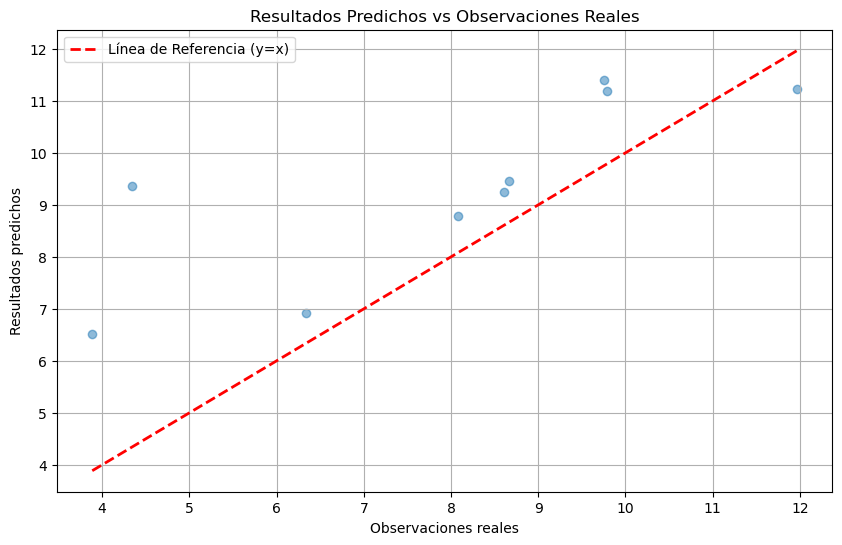

In [80]:

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()

# RFR 4 - Modelo de las variables seleccionadas por importancia - optimizado

## Optimización de hiperparámetros - Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, 
solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. 
Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.



#### Validación empleando el Out-of-Bag error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any 

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

Valor óptimo de n_estimators: 126


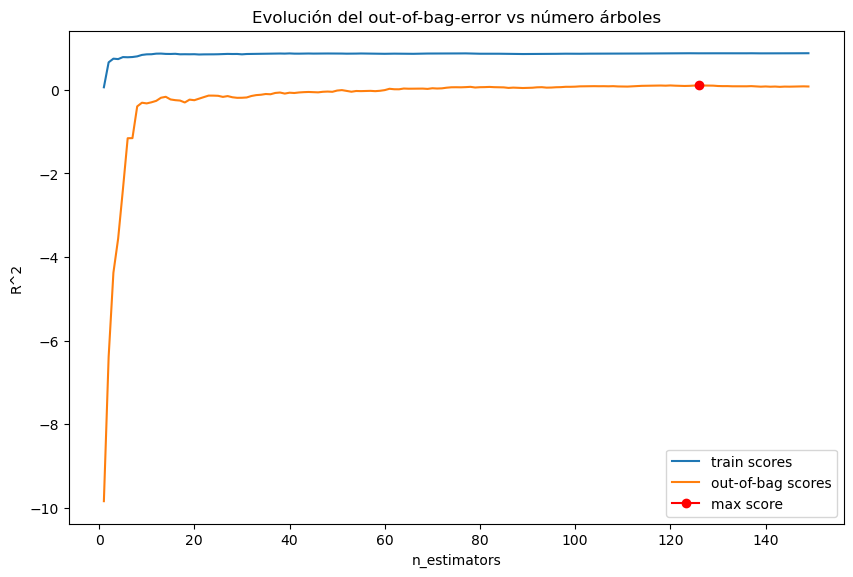

In [81]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

Valor óptimo de n_estimators: 89


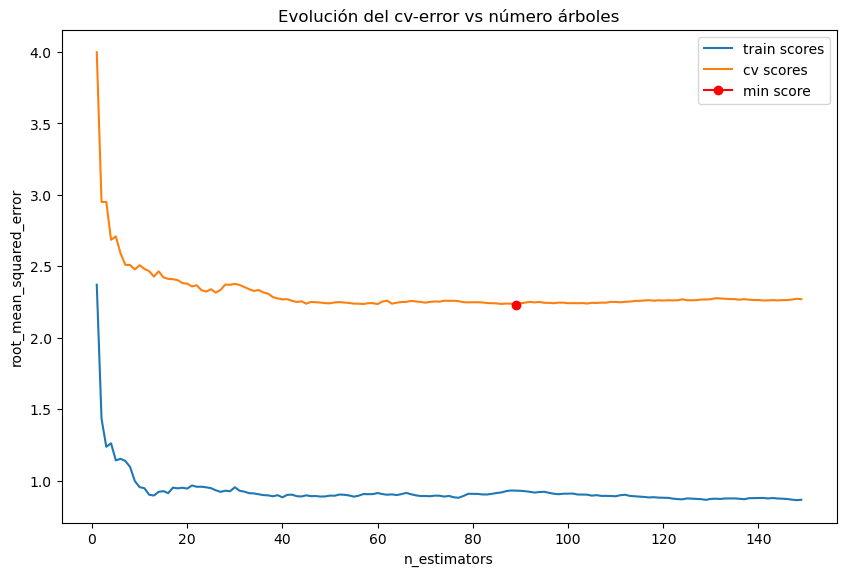

In [82]:
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Max features

El valor de máx_features es uno de los hiperparámetros más importantes de random forest, 
ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


#### Validación empleando el Out-of-Bag error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

Valor óptimo de max_features: 1


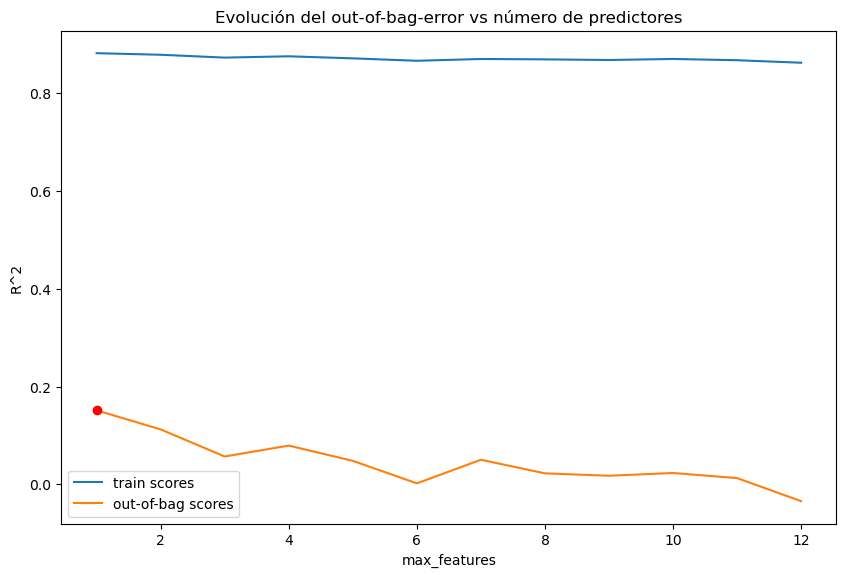

In [83]:
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 150,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array

Valor óptimo de max_features: 6


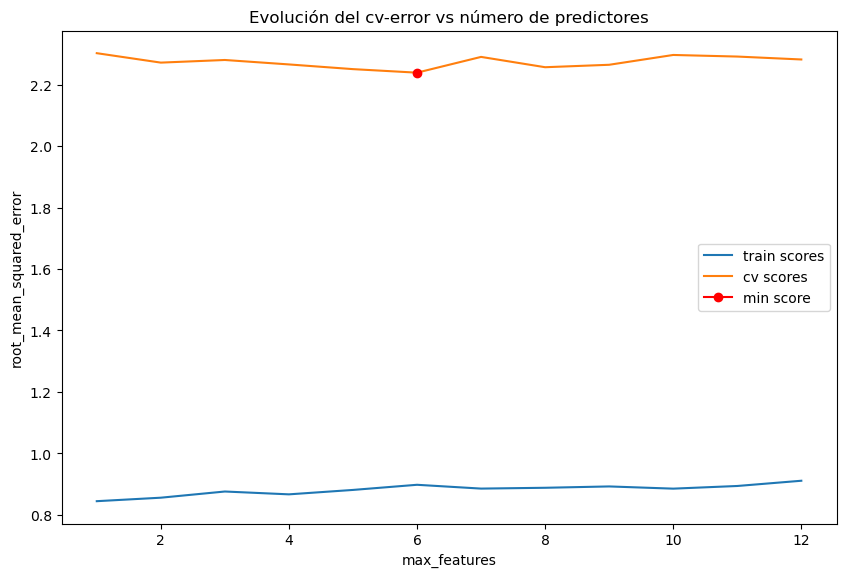

In [84]:
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 150,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Numero de arboles + Max Features (Grid search)

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo 
e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, 
ya que cada hiperparámetro interacciona con los demás. 
Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. 

#### Grid Search basado en out-of-bag error

In [85]:
### Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [None, 7, 25],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': None, 'max_features': None, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': None, 'max_features': 25, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 3, 'max_features': None, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 3, 'max_features': 25, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 10, 'max_features': None, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 10, 'max_features': 25, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 20, 'max_features': None, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓


C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo: {'max_depth': 20, 'max_features': 25, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
1,0.050429,NaN,7.0,150.0
7,0.050429,10.0,7.0,150.0
10,0.050429,20.0,7.0,150.0
4,0.039434,3.0,7.0,150.0


In [86]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0:])

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
oob_r2            0.050429
max_depth              NaN
max_features      7.000000
n_estimators    150.000000
Name: 1, dtype: float64


#### Grid Search basado en validación cruzada

In [87]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [None,7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = multiprocessing.cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
4,3,7,150,-2.162930,0.870399,-0.950330,0.106073
1,None,7,150,-2.168434,0.870372,-0.866078,0.101084
7,10,7,150,-2.168434,0.870372,-0.866078,0.101084
10,20,7,150,-2.168434,0.870372,-0.866078,0.101084


In [88]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 3, 'max_features': 7, 'n_estimators': 150} : -2.1629302882352177 neg_root_mean_squared_error


In [89]:
# Error de test del modelo final
# =============================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")


# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")

El error (rmse) de test es: 2.3168393861441623
El MAPE de test es: 0.3214762552874096


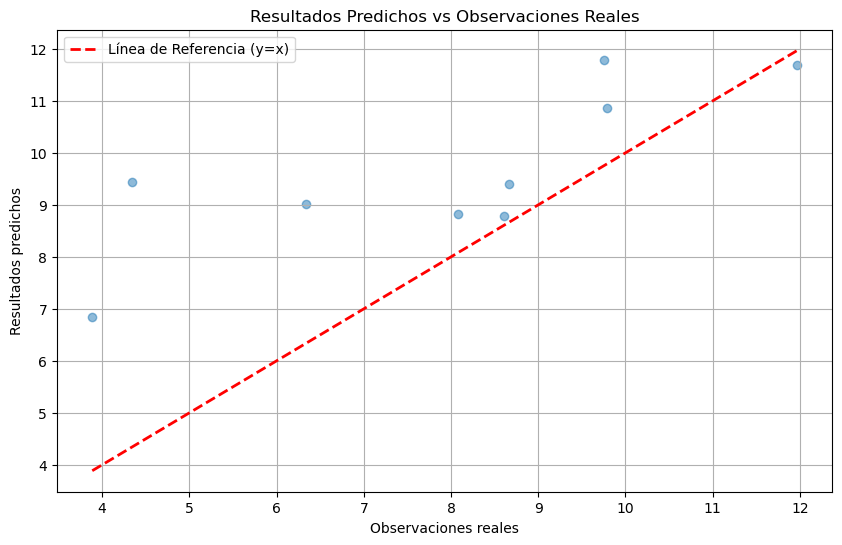

In [90]:
# Gráfico de dispersión de los resultados predichos frente a las observaciones reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()

# RFR 5 - Modelo de las variables seleccionadas por análisis exploratorio

In [112]:
df = pd.read_csv(r'D:\Documents\Documents\academico\tesis_maie\data_sets\dataframe\dataframe_tesis_final_correcciones.csv')
df = df.drop(columns = ['Lote', 'REND_range', 'REND_stde', 'Año'])
y = df[['REND_mean']].to_numpy()
y = np.ravel(y)
df = df.drop(columns = [
                       'NDRE_stde', 'NDRE_range', 
                       'SLOPE_stde','SLOPE_range', 
                       'GNDVI_stde', 'GNDVI_range',
                        'NDVI_stde', 'NDVI_range', 
                       'OSAVI_stde', 'OSAVI_range',
                       'RECI_stde', 'RECI_range',
                       'TCARIOSAVI_stde', 'TCARIOSAVI_range', 
                       'TCARI_stde', 'TCARI_range'])


new_column_names = {
    'GNDVI_mean': 'GNDVI',
    'NDRE_mean': 'NDRE',
    'NDVI_mean': 'NDVI',
    'OSAVI_mean': 'OSAVI',
    'RECI_mean': 'RECI',
    'SLOPE_mean': 'SLOPE',
    'TCARIOSAVI_mean': 'TCARIOSAVI',
    'TCARI_mean': 'TCARI',
    'REND_mean': 'REND'
}
df.rename(columns=new_column_names, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DSM         33 non-null     float64
 1   EVAPO       33 non-null     float64
 2   PP          33 non-null     float64
 3   TEMP        33 non-null     float64
 4   GNDVI       33 non-null     float64
 5   NDRE        33 non-null     float64
 6   NDVI        33 non-null     float64
 7   OSAVI       33 non-null     float64
 8   RECI        33 non-null     float64
 9   SLOPE       33 non-null     float64
 10  TCARIOSAVI  33 non-null     float64
 11  TCARI       33 non-null     float64
 12  REND        33 non-null     float64
dtypes: float64(13)
memory usage: 3.5 KB


In [113]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = ["REND"]), #,  'Rend_std' ,'Rend_var', 'AÃ±o']),
                                        y,
                                        random_state = 123
                                    )

# Creación del modelo
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 24,
            criterion    = 'squared_error', #'mse' 
            max_depth    = None,
            max_features = 11,
            bootstrap    = True,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

RandomForestRegressor(max_features=11, n_estimators=24, n_jobs=-1,
                      random_state=123)

In [114]:
# Error de test del modelo 
# ========================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")

El error (rmse) de test es: 1.8773980547724698
El MAPE de test es: 0.24797314449770294


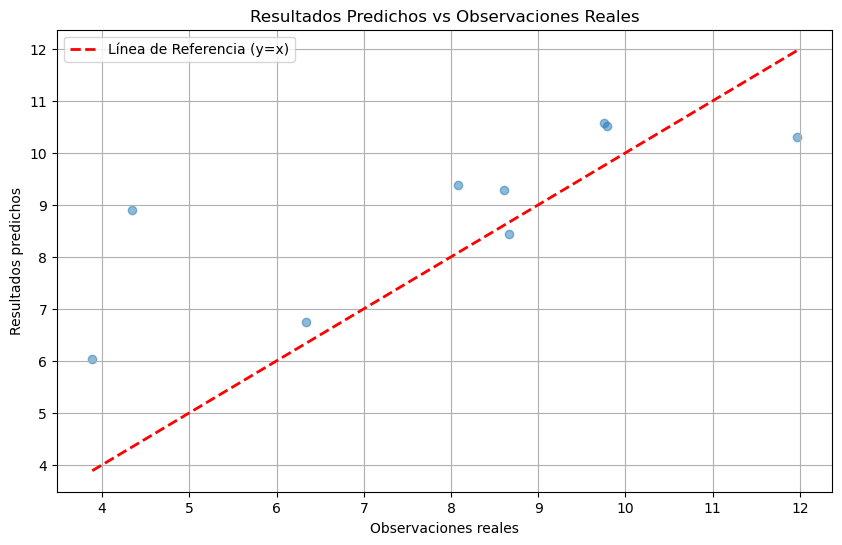

In [115]:
# Gráfico de dispersión de los resultados predichos frente a las observaciones reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()

## Análisis de las Relaciones parciales entre las variables del modelo RFR -5

Computing partial dependence plots...


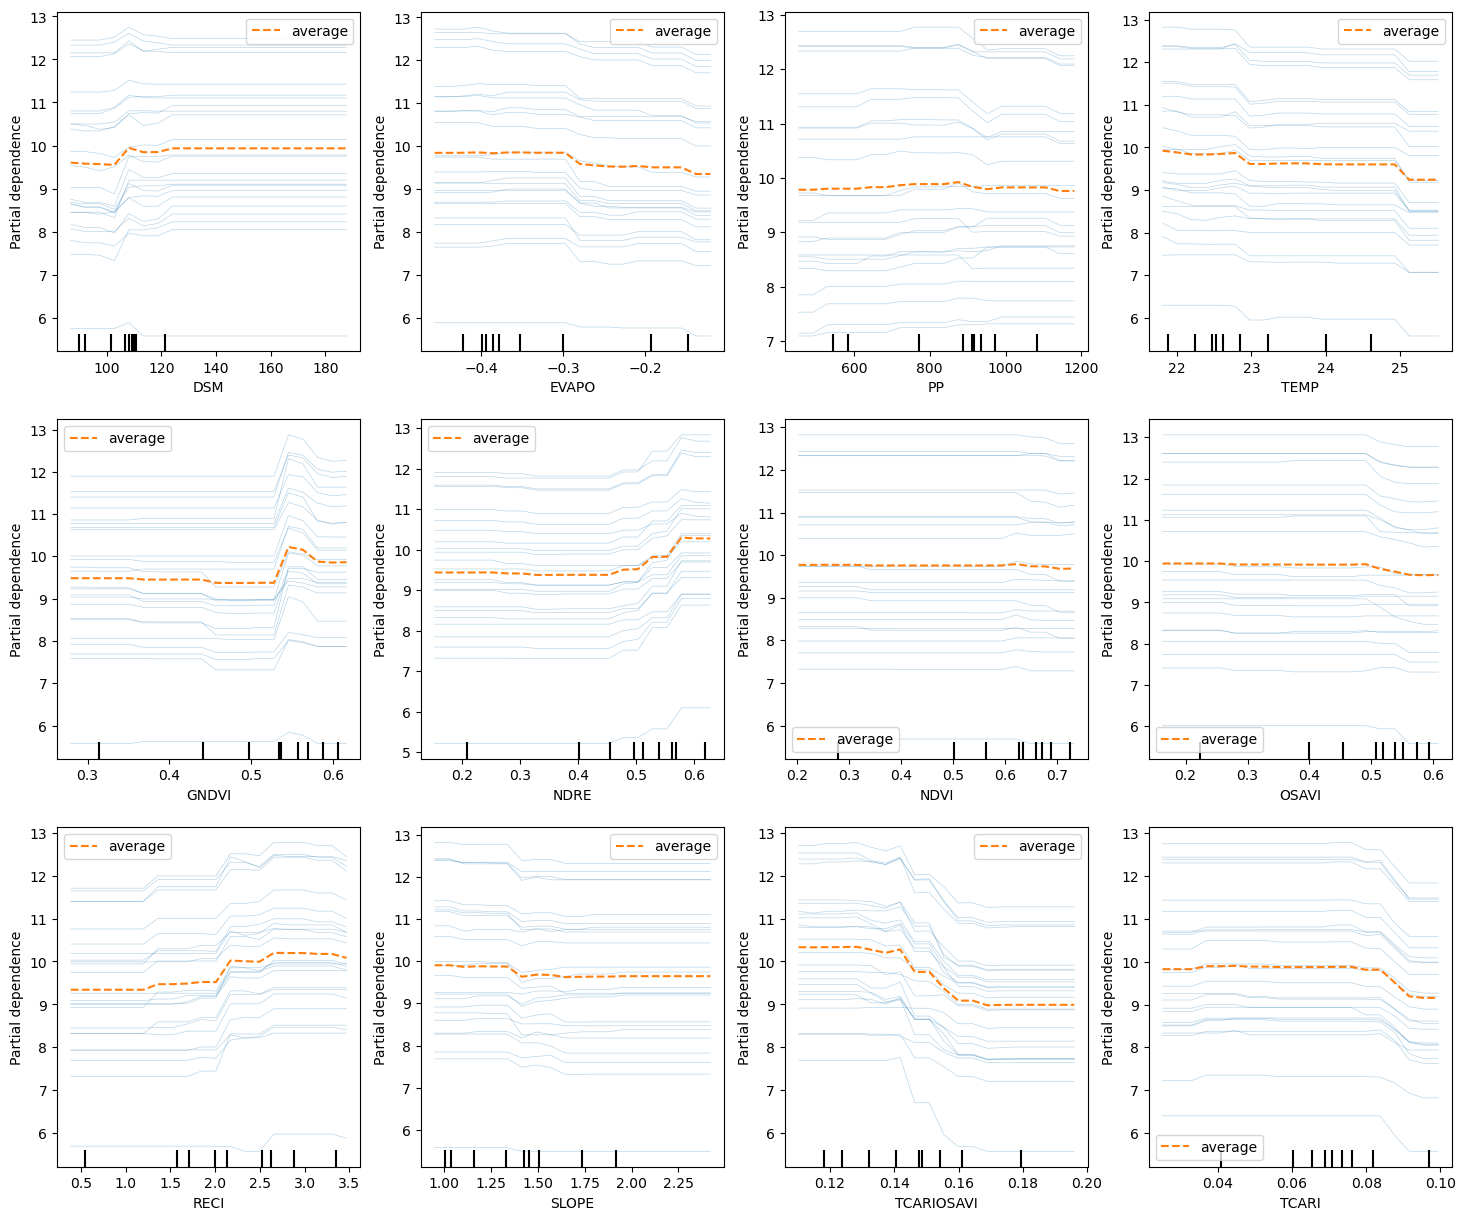

In [117]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 2,
    "n_cols": 4  # Ajusta el número de columnas para la presentación de los gráficos
}      

# Lista de las 28 variables que deseas analizar
variables_to_plot = [ 'DSM',
'EVAPO',
'PP',
'TEMP',
'GNDVI',
'NDRE',
'NDVI',
'OSAVI',
'RECI',
'SLOPE',
'TCARIOSAVI',
'TCARI']


print("Computing partial dependence plots...")
tic = time()

# Calcular el número total de gráficos a generar
total_plots = len(variables_to_plot)

# Calcular el número de filas necesarias para acomodar los gráficos
n_rows = (total_plots - 1) // common_params["n_cols"] + 1

# Crear una figura con subplots
fig, axes = plt.subplots(n_rows, common_params["n_cols"], figsize=(18, 15))


# Iterar a través de las variables y generar los gráficos de dependencia parcial
for i, variable in enumerate(variables_to_plot):
    row = i // common_params["n_cols"]
    col = i % common_params["n_cols"]
    
    # Generar el gráfico para la variable actual
    display = PartialDependenceDisplay.from_estimator(
        modelo,
        X_train,
        features=[variable],
        kind="both",
        ax=axes[row, col],  # Usar el subplot correspondiente
        **common_params,
    )
    display.figure_.suptitle("")

# RFR 6 - Modelo de las variables seleccionadas por análisis exploratorio - optimizado

## Optimización de hiperparámetros - Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, 
solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. 
Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.



#### Validación empleando el Out-of-Bag error

C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\Anaconda3\envs\miner-tool\lib\site-packages\sklearn\ensem

Valor óptimo de n_estimators: 115


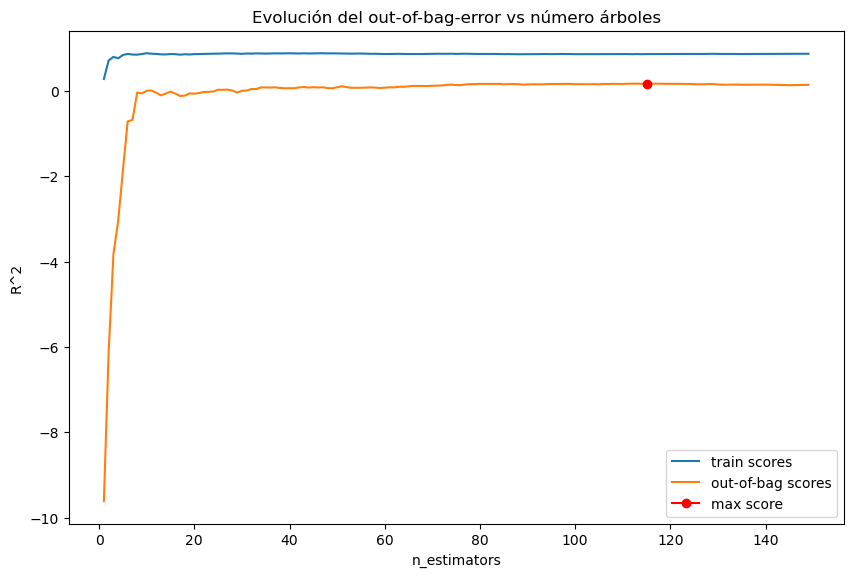

In [95]:
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

Valor óptimo de n_estimators: 12


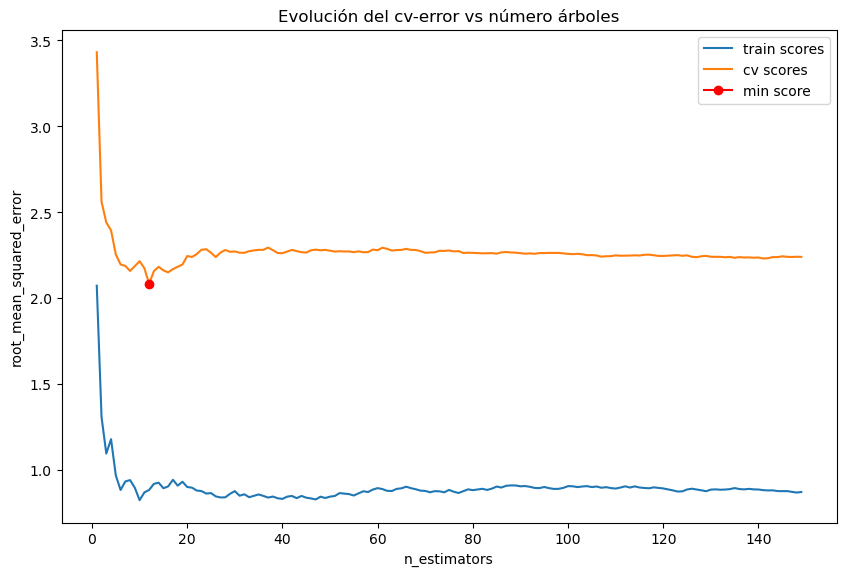

In [96]:
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 1)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 0.4,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Max features

El valor de máx_features es uno de los hiperparámetros más importantes de random forest, 
ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


#### Validación empleando el Out-of-Bag error

Valor óptimo de max_features: 1


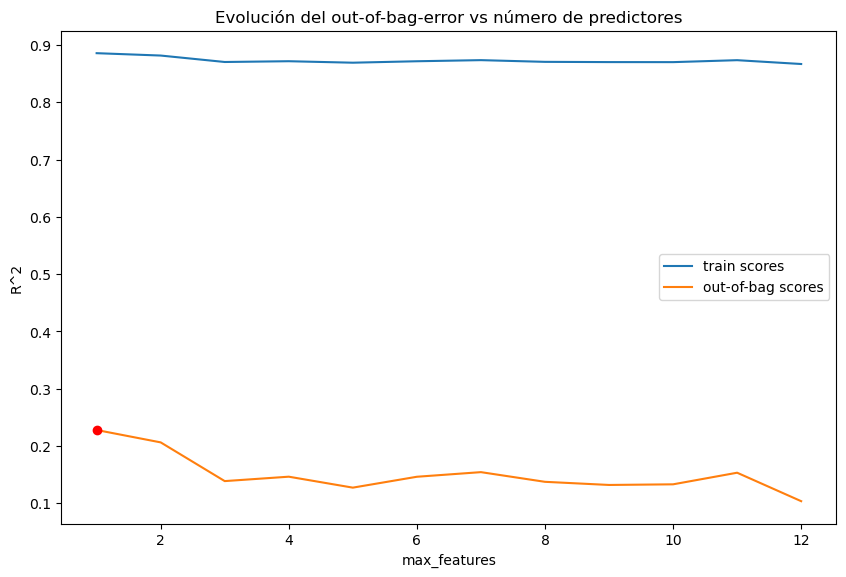

In [97]:
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 150,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

#### Validación empleando k-cross-validation y neg_root_mean_squared_error

Valor óptimo de max_features: 3


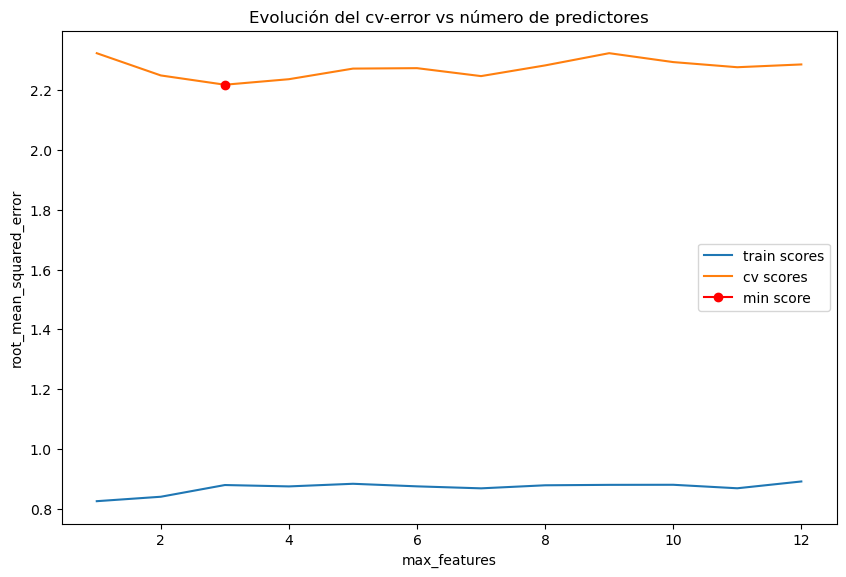

In [98]:
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelo = RandomForestRegressor(
                n_estimators = 150,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(10, 6.4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Optimización de hiperparámetros - Numero de arboles + Max Features (Grid search)

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo 
e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, 
ya que cada hiperparámetro interacciona con los demás. 
Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. 

#### Grid Search basado en out-of-bag error

In [99]:
### Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [None, 7, 25],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 25, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': None, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 25, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
1,0.154437,NaN,7.0,150.0
7,0.154437,10.0,7.0,150.0
10,0.154437,20.0,7.0,150.0
4,0.137227,3.0,7.0,150.0


In [ ]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0:])

#### Grid Search basado en validación cruzada

In [100]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [None,7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = multiprocessing.cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
4,3,7,150,-2.127466,0.995886,-0.939264,0.123077
1,None,7,150,-2.145209,0.993298,-0.841794,0.114452
7,10,7,150,-2.145209,0.993298,-0.841794,0.114452
10,20,7,150,-2.145209,0.993298,-0.841794,0.114452


In [101]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 3, 'max_features': 7, 'n_estimators': 150} : -2.127466004623812 neg_root_mean_squared_error


In [102]:
# Error de test del modelo final
# =============================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")


# Calcula el MAPE
mape = mean_absolute_percentage_error(
    y_true=y_test,
    y_pred=predicciones
)

print(f"El MAPE de test es: {mape}")

El error (rmse) de test es: 1.9962755260731873
El MAPE de test es: 0.280593029578672


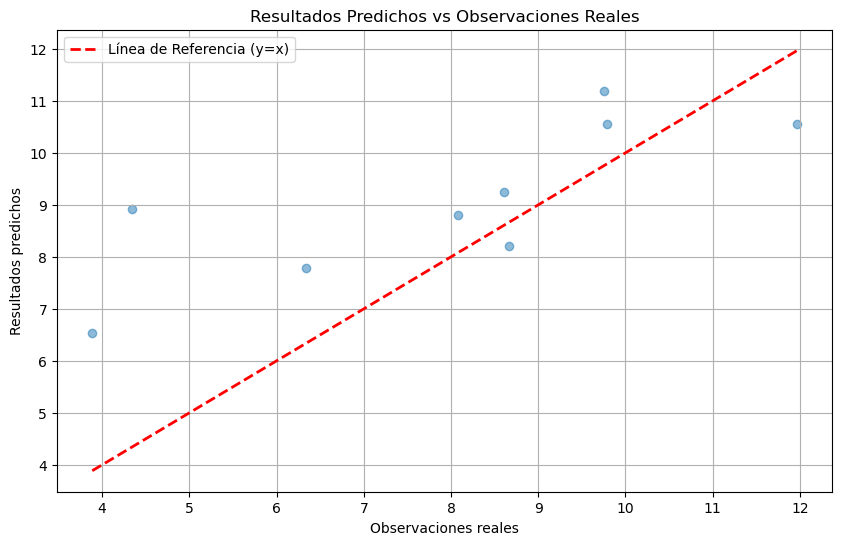

In [104]:
# Gráfico de dispersión de los resultados predichos frente a las observaciones reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicciones, alpha=0.5)
plt.xlabel("Observaciones reales")
plt.ylabel("Resultados predichos")
plt.title("Resultados Predichos vs Observaciones Reales")

# Línea de referencia (y=x)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color='red', linestyle='--', linewidth=2, label="Línea de Referencia (y=x)")

plt.legend()
plt.grid(True)
plt.show()